In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from longitudinal.settings.constants import DATA_PATH

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_parquet(DATA_PATH + "PROCESSED/train_data_CLEANED_V3.parquet")
test = pd.read_parquet(DATA_PATH + "PROCESSED/test_data_CLEANED_V3.parquet")

train.drop(columns=["study_parent_id_new", "person_id_parent", "height_cm_child"], inplace=True)
test.drop(columns=["study_parent_id_new", "person_id_parent", "height_cm_child"], inplace=True)
train.fillna(0, inplace=True)

x_train, y_train = train.drop(columns=["height_cm_target"]), train["height_cm_target"].values
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((3043, 29), (3043,))

In [3]:
test[test["height_cm_target"].isna()]

,person_id_child,sex_assigned_at_birth_child,study_parent_sex,AgeGr_child,generation_child,height_cm_imputed_child,sex_assigned_at_birth_parent,height_cm_parent,generation_parent,height_cm_imputed_parent,...,height_cm_lag_4_parent,height_cm_lag_5_child,height_cm_lag_5_parent,height_cm_lag_6_child,height_cm_lag_6_parent,height_cm_lag_7_child,height_cm_lag_7_parent,growth_spurt_child,growth_spurt_parent,height_cm_target
13,2831,0,1,9.0,2,133.301016,NaN,NaN,NaN,NaN,...,NaN,104.646787,NaN,97.065804,NaN,88.044782,NaN,0,0,NaN
27,2823,1,1,9.0,2,130.754785,0.0,131.696890,1.0,131.696890,...,110.011684,107.008163,103.812811,99.601210,95.905909,91.161540,85.473386,0,0,NaN
41,2822,1,1,9.0,2,137.026283,NaN,NaN,NaN,NaN,...,NaN,107.812102,NaN,100.286270,NaN,90.457748,NaN,0,0,NaN
55,2821,0,1,9.0,2,143.430368,0.0,130.732974,1.0,130.732974,...,108.427120,108.813557,101.357595,98.884833,93.459453,87.745339,82.745701,0,0,NaN
69,2820,1,1,9.0,2,129.789793,0.0,NaN,1.0,133.088497,...,107.906615,103.852288,100.768398,97.117508,94.338745,87.275235,85.740010,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,2508,0,1,9.0,2,142.476229,NaN,NaN,NaN,NaN,...,NaN,107.352638,NaN,97.965989,NaN,88.858038,NaN,0,0,NaN
1095,2506,0,0,9.0,2,139.459044,1.0,142.997282,1.0,142.997282,...,118.652808,109.749886,110.711241,102.487697,103.697442,92.439675,93.923465,0,0,NaN
1109,2504,0,0,9.0,2,129.174593,1.0,130.702941,1.0,130.702941,...,108.878133,102.629709,102.832376,95.011010,93.737598,86.669085,86.875370,0,0,NaN
1119,2503,0,0,9.0,2,135.873397,NaN,NaN,NaN,NaN,...,NaN,108.233606,NaN,100.187839,NaN,89.375824,NaN,0,0,NaN


In [4]:
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of boosting rounds
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    "max_depth": [3, 5, 7, 9],  # Maximum depth of trees
    "subsample": [0.6, 0.8, 1.0],  # Fraction of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features used per tree
    "gamma": [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
    "reg_alpha": [0, 0.01, 0.1, 1.0],  # L1 regularization
    "reg_lambda": [1.0, 2.0, 5.0]  # L2 regularization
}

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=30, 
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Train MAE:", -random_search.best_score_)

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **random_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.2f} cm")
print(f"Test RMSE: {rmse:.2f} cm")

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best Train MAE: 1.2765426452348472
Test MAE: 1.25 cm
Test RMSE: 1.73 cm


In [5]:
test = test[test["AgeGr_child"] < 9]
x_test, y_test = test.drop(columns=["height_cm_target"]), test["height_cm_target"].values

x_test.shape, y_test.shape

((1046, 29), (1046,))

In [6]:
# model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **random_search.best_params_)
# model.fit(x_test, y_test)
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE: {mae:.2f} cm")
print(f"Test RMSE: {rmse:.2f} cm")

Test MAE: 7.92 cm
Test RMSE: 16.97 cm


In [7]:
np.isnan(y_test).sum()

np.int64(0)

In [8]:
y_test[y_test == np.nan]

array([], dtype=float64)

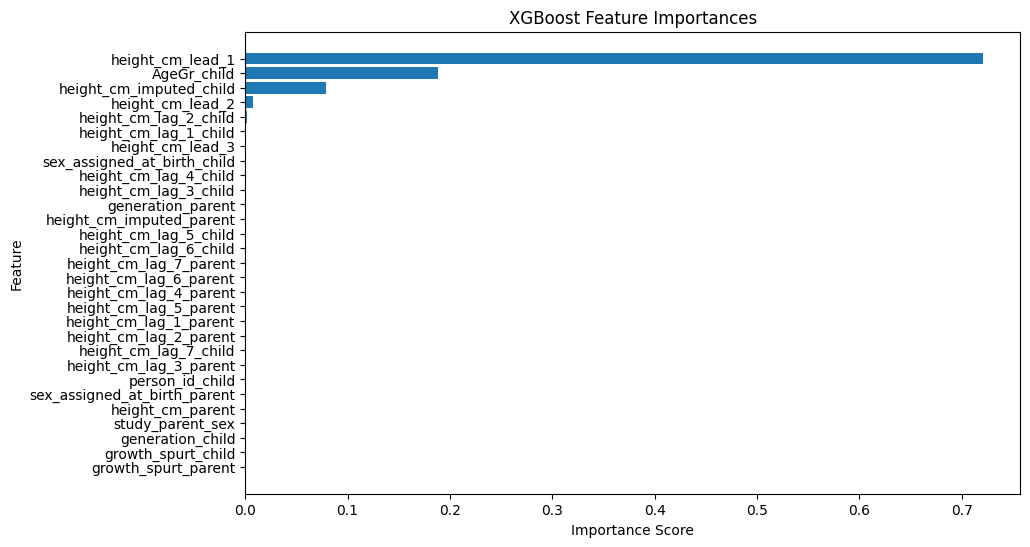

In [9]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
importance_df["Feature"] = importance_df["Feature"].astype(str)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()